In [61]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.mplot3d import Axes3D

In [66]:
# global variables
dt = 0.1 # 10* dt from the computation
steps = 100

In [67]:
par_dir = './train-track-static/seed_687_1/'
dir = par_dir + 'POSTPRO/'

# Contact force distribution

In [68]:
prenom = 'CONTACT_FORCE_DISTRIBUTION_'
ext = '.dat'
# check the number of files starting with prenom
nb_files = len([name for name in os.listdir(dir) if name.startswith(prenom)])
dat = np.zeros((4,nb_files))
dat.shape
for i in range(1,nb_files):
    nom = prenom + str(i).zfill(7) + ext
    rf = np.loadtxt(os.path.join(dir,nom))
    dat[:,i] = rf


<AxesSubplot:title={'center':'N_r and N_rn'}, xlabel='time'>

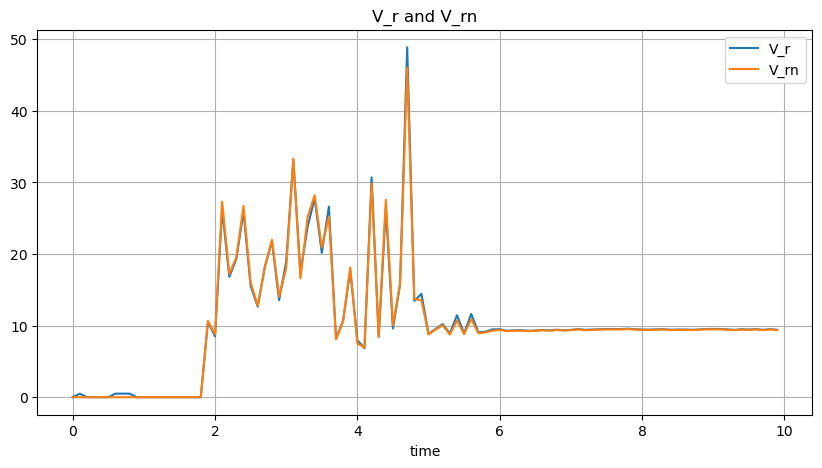

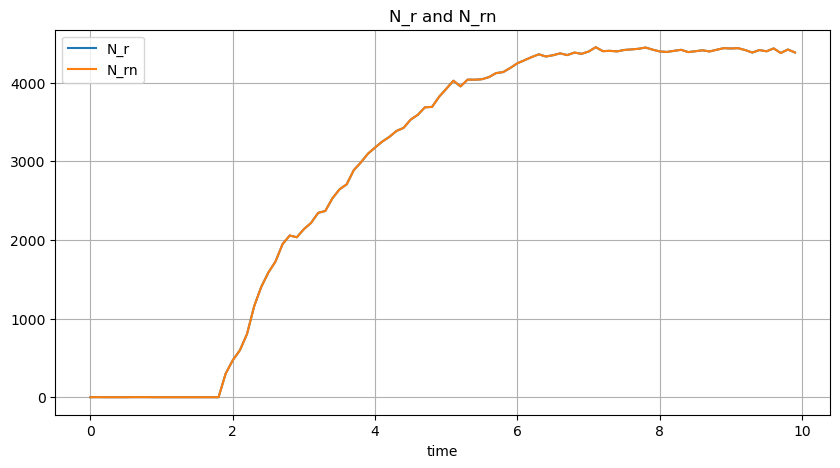

In [69]:
cfdist = pd.DataFrame(dat.T, columns=['V_r','N_r','V_rn','N_rn'])
steps = np.arange(0,dt*nb_files,dt)
cfdist['time'] = steps
# replace -inf or valus greater than 1e6 values with 0
cfdist[cfdist > 1e6] = np.inf
cfdist_fixed = cfdist.replace([np.inf, -np.inf], np.nan).fillna(0)
# replace any values greater than 1e6 with 0
cfdist_fixed.head()
cfdist_fixed.plot(x='time',y=['V_r','V_rn'],figsize=(10,5), grid=True, title='V_r and V_rn')
cfdist_fixed.plot(x='time',y=['N_r','N_rn'],figsize=(10,5), grid=True, title='N_r and N_rn')


# Coordination number

In [70]:
coor = np.loadtxt(dir+'COORDINATION_NUMBER.DAT')
coor_df = pd.DataFrame(coor, columns=['t', 'c_0','c_+', 'c_-', 'c'])

<AxesSubplot:title={'center':'Coordination number'}, xlabel='t'>

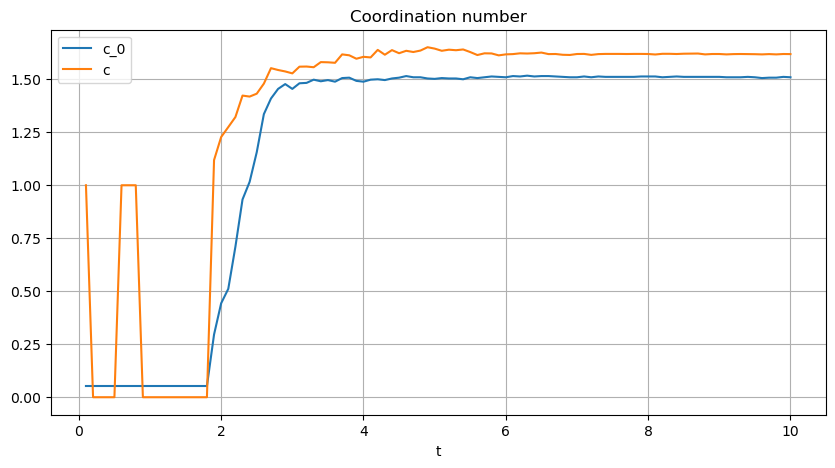

In [71]:
coor_df.plot(x='t',y=['c_0','c'],figsize=(10,5), grid=True, title='Coordination number')

# Body tracking

In [182]:
prenom = 'BODY_'
ext = '.dat'
# check the number of files starting with prenom
nb_files = len([name for name in os.listdir(dir) if name.startswith(prenom)])
with open(par_dir+'dict.txt') as file:
    dict = json.load(file)
track_every = dict['Track Every']
bt = np.zeros((100,13,nb_files))
for i in range(2,nb_files,track_every):
    j=0
    nom = prenom + str(i).zfill(7) + ext
    rf = np.loadtxt(os.path.join(dir,nom))
    bt[:,:,j] = rf
    j+=1

print(bt.shape)

(100, 13, 51)


In [183]:
df = pd.DataFrame(bt[:,:,0], columns=['id','x','y','z','vx','vy','vz','wx','wy','wz','fx','fy','fz'])
df['x'][0]

-3.2928186

In [184]:
# create a function to plot particles movement in 3d
def plot_displacement(bt, par_dir=par_dir, n=1, filename='particle_displacement.gif'):
    [os.mkdir(os.path.join(par_dir,'plots')) if not os.path.exists(os.path.join(par_dir,'plots')) else None]
    filenames = []
    filename = par_dir+'plots/'+filename
    for t in range(len(bt)):
        figure = plt.figure()
        ax = figure.add_subplot(111, projection='3d')
        ax.scatter(bt[t,1,n], bt[t,1,n], bt[t,1,n], c='r', marker='o')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim(bt[:,:,n].min(), bt[:,:,n].max())
        ax.set_ylim(bt[:,:,n].min(), bt[:,:,n].max())
        ax.set_zlim(bt[:,:,n].min(), bt[:,:,n].max())
        ax.set_title(f'Particle {n} displacement at time step {t}')
        fname = par_dir+f'plots/particle_{n}_displacement_{t}.png'
        plt.savefig(fname)
        filenames.append(fname)     
        plt.close()
    with imageio.get_writer(filename, mode='I') as writer:
        for filename in filenames:
            image = imageio.v2.imread(filename)
            writer.append_data(image)
            os.remove(filename)
    print('GIF created')
    

In [185]:
n = 1
plot_displacement(bt, par_dir=par_dir, n=n, filename=f'particle_{n}_displacement.gif')


c:\Users\PMMH11231\AppData\Local\anaconda3\envs\lmgc90\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  del sys.path[0]
c:\Users\PMMH11231\AppData\Local\anaconda3\envs\lmgc90\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  
c:\Users\PMMH11231\AppData\Local\anaconda3\envs\lmgc90\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  from ipykernel import kernelapp as app


GIF created


In [186]:
bt[:,:,2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
import matplotlib.pyplot as plt
import imageio

# Assuming x, y, z are your lists of coordinates
x = [...]  # Your x-coordinates
y = [...]  # Your y-coordinates
z = [...]  # Your z-coordinates

filenames = []

for i in range(len(x)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[i], y[i], z[i], c='r', marker='o')

    # Setting limits for axes
    ax.set_xlim([min(x), max(x)])
    ax.set_ylim([min(y), max(y)])
    ax.set_zlim([min(z), max(z)])

    # Save the frame
    filename = f'{i}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

# Create a gif
with imageio.get_writer('particle_motion.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
for filename in filenames:
    os.remove(filename)
